In [1]:
!pip install opencv-python
!pip install numpy
!pip install tensorflow
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install tqdm


In [2]:
import os, cv2, random, time, shutil, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm as tqdm
import json

In [3]:
labels_df = pd.read_csv('C:/Users/HP/Desktop/Dog/labels.csv')
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
labels_df.describe()

,id,breed
count,10222,10222
unique,10222,120
top,000bec180eb18c7604dcecc8fe0dba07,scottish_deerhound
freq,1,126


In [5]:
dog_breeds = sorted(list(set(labels_df['breed'])))
n_classes = len(dog_breeds)
class_to_num = dict(zip(dog_breeds, range(n_classes)))
train_dir = 'C:/Users/HP/Desktop/Dog/train/'
test_dir = 'C:/Users/HP/Desktop/Dog/test/'

In [6]:
import tensorflow as tf
from tensorflow.random import shuffle
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
import gc

In [7]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [8]:
for layer in base_model.layers:
    layer.trainable = False

In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
def load_train_images(dir_path):
    x_train, y_train = [], []
    for img_path in os.listdir(dir_path):
        img = load_img(os.path.join(dir_path, img_path), target_size=(128, 128, 1))
        x_train.append(preprocess_input(np.array(img).astype("float32")))
        img_name = img_path.split('/')[-1].split('.')[0]
        class_id = class_to_num[labels_df[labels_df['id'] == img_name]['breed'].values[0]]
        y_train.append(class_id)
    x_train = np.array(x_train)
    y_train = to_categorical(y_train, num_classes=n_classes)
    
    return x_train, y_train

In [12]:
x_train, y_train = load_train_images(train_dir)
print(x_train.shape)
print(y_train.shape)

(10222, 128, 128, 3)
(10222, 120)


In [13]:
def load_test_images(dir_path):
    x_test = []
    for img_path in os.listdir(dir_path):
        img = load_img(os.path.join(dir_path, img_path), target_size=(128, 128, 1))
        x_test.append(preprocess_input(np.array(img).astype("float32")))
    x_test = np.array(x_test)
    return x_test

In [14]:
x_test = load_test_images(test_dir)
print(x_test.shape)

(10357, 128, 128, 3)


In [15]:
history = model.fit(x_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
160/160 [==============================] - 216s 1s/step - loss: 3.2461 - accuracy: 0.2731
Epoch 2/3
160/160 [==============================] - 229s 1s/step - loss: 2.0861 - accuracy: 0.4508
Epoch 3/3
160/160 [==============================] - 239s 1s/step - loss: 1.8178 - accuracy: 0.5046


In [16]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [17]:
def plot_model_history(history, fig_title, shape=(24,6)):
    fig, ax = plt.subplots(1,2, figsize=shape)
    fig.suptitle(fig_title, fontsize=16)
    ax[0].plot(history.history['loss'],     color='b', label="Training loss")
    #ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.history['accuracy'],     color='b', label="Training accuracy")
    #ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.show()

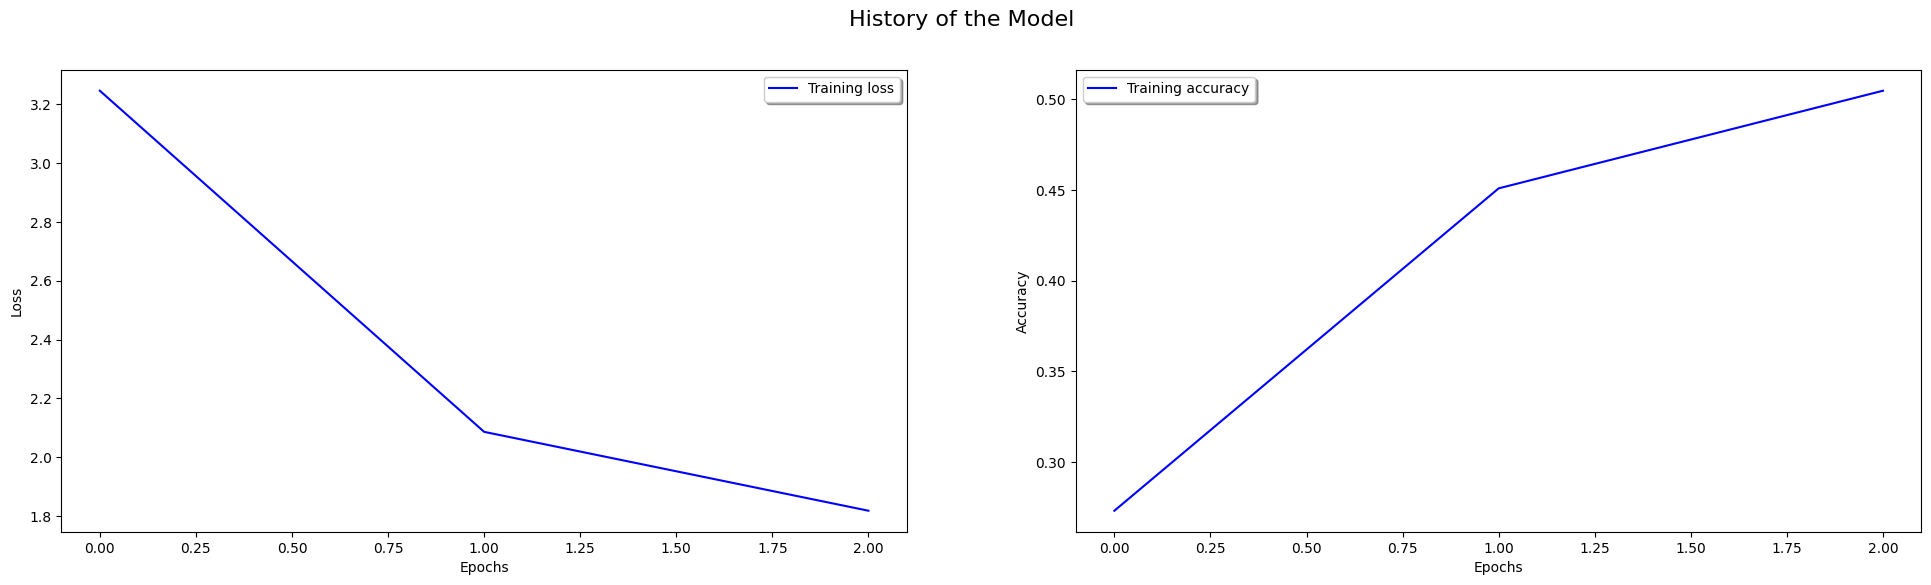

In [18]:
plot_model_history(history, 'History of the Model')

In [19]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
def load_train_images(dir_path):
    x_train, y_train = [], []
    for img_path in os.listdir(dir_path):
        img = load_img(os.path.join(dir_path, img_path), target_size=(128, 128, 1))
        x_train.append(inception_preprocessor(np.array(img).astype("float32")))
        img_name = img_path.split('/')[-1].split('.')[0]
        class_id = class_to_num[labels_df[labels_df['id'] == img_name]['breed'].values[0]]
        y_train.append(class_id)
    x_train = np.array(x_train)
    y_train = to_categorical(y_train, num_classes=n_classes)
    
    return x_train, y_train
def load_test_images(dir_path):
    x_test = []
    for img_path in os.listdir(dir_path):
        img = load_img(os.path.join(dir_path, img_path), target_size=(128, 128, 1))
        x_test.append(inception_preprocessor(np.array(img).astype("float32")))
    x_test = np.array(x_test)
    return x_test
x_train, y_train = load_train_images(train_dir)
print(x_train.shape)
print(y_train.shape)
x_test = load_test_images(test_dir)
print(x_test.shape)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#from keras.applications.xception import Xception, preprocess_input
#xception_preprocessor = preprocess_input
#from keras.applications.nasnet import NASNetLarge, preprocess_input
#nasnet_preprocessor = preprocess_input
#from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
#inc_resnet_preprocessor = preprocess_input

#models = [InceptionV3,  InceptionResNetV2, Xception, ]
#preprocs = [inception_preprocessor,  inc_resnet_preprocessor, xception_preprocessor]

(10222, 128, 128, 3)
(10222, 120)
(10357, 128, 128, 3)


In [20]:
history = model.fit(x_train, y_train, epochs=3, batch_size=64)

Epoch 1/3
160/160 [==============================] - 86s 511ms/step - loss: 3.6994 - accuracy: 0.2186
Epoch 2/3
160/160 [==============================] - 80s 502ms/step - loss: 2.5936 - accuracy: 0.3665
Epoch 3/3
160/160 [==============================] - 81s 509ms/step - loss: 2.3487 - accuracy: 0.4069


In [21]:
model.save('saved_model/my_model2')

INFO:tensorflow:Assets written to: saved_model/my_model2\assets


INFO:tensorflow:Assets written to: saved_model/my_model2\assets


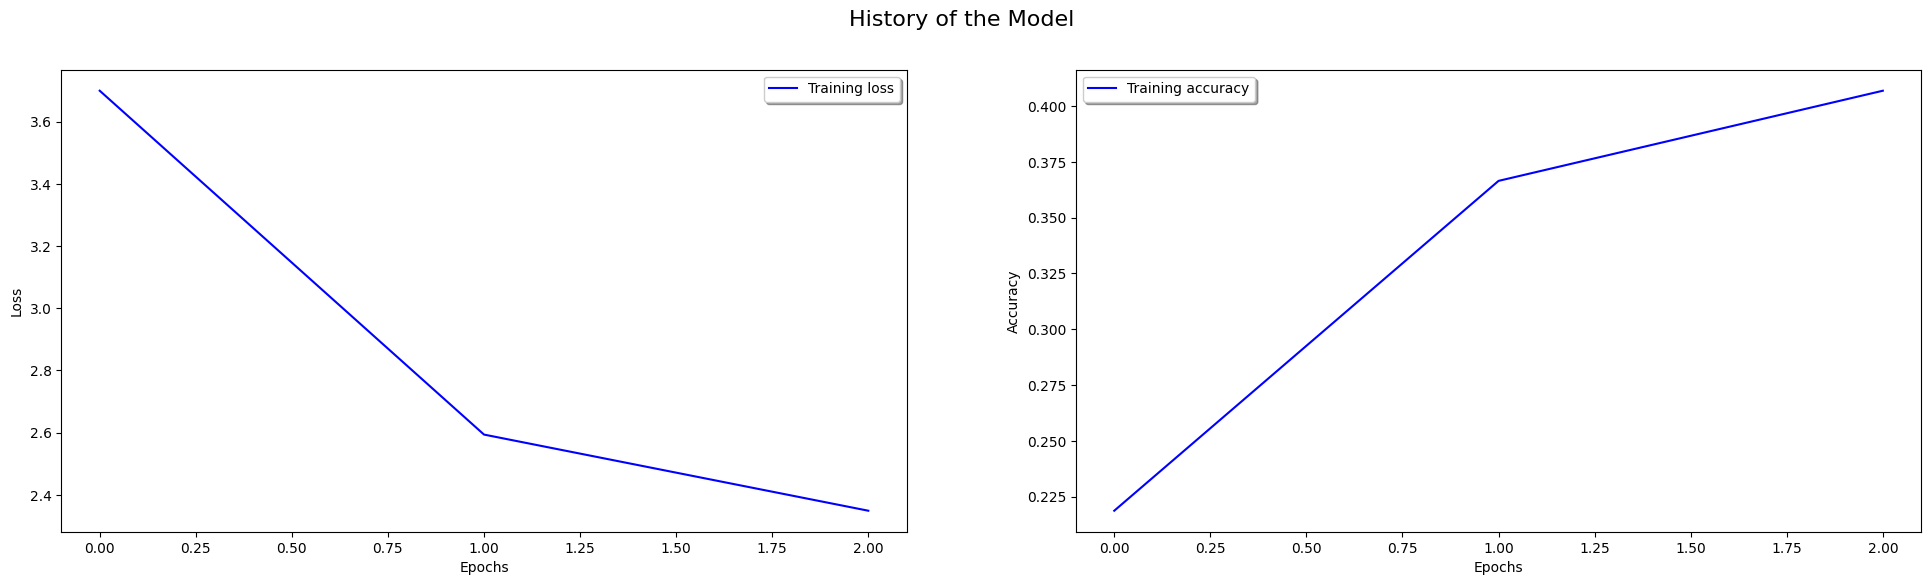

In [22]:
def plot_model_history(history, fig_title, shape=(24,6)):
    fig, ax = plt.subplots(1,2, figsize=shape)
    fig.suptitle(fig_title, fontsize=16)
    ax[0].plot(history.history['loss'],     color='b', label="Training loss")
    #ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.history['accuracy'],     color='b', label="Training accuracy")
    #ax[1].plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    plt.show()
plot_model_history(history, 'History of the Model')